In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import os
from operator import itemgetter
from sklearn.cluster import AgglomerativeClustering
nltk.download('vader_lexicon')
from sklearn.metrics import silhouette_score
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from sklearn.cluster import KMeans
from gensim import corpora
from gensim.models import LsiModel, LdaModel
from gensim.models.coherencemodel import CoherenceModel
from nltk.tokenize import RegexpTokenizer
from gensim.models import TfidfModel
from nltk.sentiment.vader import SentimentIntensityAnalyzer


def compute_coherence_values(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    """
    Input   : dictionary : Gensim dictionary
              corpus : Gensim corpus
              texts : List of input texts
              stop : Max num of topics
    purpose : Compute c_v coherence for various number of topics
    Output  : model_list : List of LSA topic models
              coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, stop, step):
        # generate LSA model
        #model = LsiModel(doc_term_matrix, num_topics=num_topics, id2word = dictionary)  # train model
        model = LdaModel(doc_term_matrix, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

def plot_graph(doc_clean,start, stop, step, doc_term_matrix,dictionary):
    model_list, coherence_values = compute_coherence_values(dictionary, doc_term_matrix,doc_clean, stop, start, step)
    # Show graph
    #print(coherence_values)
    x = range(start, stop, step)
    plt.plot(x, coherence_values)
    plt.xlabel("Number of Topics")
    plt.ylabel("Coherence score")
    plt.legend(("coherence_values"), loc='best')
    plt.show()
    c = coherence_values.index(max(coherence_values))
    return start + c

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/menis/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
data = pd.read_json("7postElection.json")
vader = SentimentIntensityAnalyzer()
text = data["text"].tolist()
scores = list()
positive = list()
negative = list()
neut = list()
for t in text:
    scores.append(vader.polarity_scores(t)['compound'])
    positive.append(vader.polarity_scores(t)['pos'])
    negative.append(vader.polarity_scores(t)['neg'])
    neut.append(vader.polarity_scores(t)['neu'])
data["vaderScore"] = scores


In [3]:
data = data[data["is_retweet"] == False]

data.rename(index=str, columns={"year": "date_year"},inplace=True)
data.rename(index=str, columns={"month": "date_month"},inplace=True)

data.drop(["hour","in_reply_to_user_id_str","is_retweet","text","modded_text","modded1","date"],axis=1,inplace=True)
data.corr()

,favorite_count,retweet_count,date_month,date_year,week_year,labels,vaderScore
favorite_count,1.000000,0.891237,-0.164023,0.185635,-0.164811,0.076417,-0.098971
retweet_count,0.891237,1.000000,-0.089613,0.144045,-0.090638,0.090506,-0.166127
date_month,-0.164023,-0.089613,1.000000,-0.302847,0.984279,-0.032168,0.064430
date_year,0.185635,0.144045,-0.302847,1.000000,-0.302369,0.021680,-0.019233
week_year,-0.164811,-0.090638,0.984279,-0.302369,1.000000,-0.034066,0.066510
labels,0.076417,0.090506,-0.032168,0.021680,-0.034066,1.000000,-0.129911
vaderScore,-0.098971,-0.166127,0.064430,-0.019233,0.066510,-0.129911,1.000000


In [4]:
data

,favorite_count,retweet_count,date_month,date_year,week_year,noTags_punct,modded1_stemmed,labels,vaderScore
30192,126230,32665,1,2017,52,to all americans many blessings to you all...,american mani bless look forward wonder ...,1,0.8908
30198,124024,29248,1,2017,1,well the new year begins we will together make...,well new year begin togeth make america...,3,0.8034
30199,63340,17411,1,2017,1,chicago murder rate is record setting 4331 sh...,chicago murder rate record set 4331 sho...,2,-0.8622
30200,13862,3948,1,2017,1,cnn just released a book called unprecedented ...,cnn releas book call unpreced explor 20...,3,-0.6643
30201,47285,9057,1,2017,1,various media outlets and pundits say that i t...,variou media outlet pundit say thought ...,5,-0.7003
30202,62670,13437,1,2017,1,i thought and felt i would win big easily over...,thought felt would win big easili fabl ...,3,0.6369
30203,92256,26703,1,2017,1,north korea just stated that it is in the fina...,north korea state final stage develop n...,0,0.3595
30204,64480,17507,1,2017,1,china has been taking out massive amounts of m...,china take massiv amount money wealth u...,0,0.4948
30205,73104,18864,1,2017,1,general motors is sending mexican made model o...,gener motor send mexican made model che...,0,0.4926
30206,58809,14481,1,2017,1,people must remember that obamacare just doesn...,peopl must rememb obamacar doesnt work ...,5,0.0000


In [13]:
majorCluster = 2
d1 = data[data["labels"] == majorCluster ]


stemmed_words = pd.Series(' '.join(d1['modded1_stemmed']).split()).value_counts()
print(stemmed_words)

stemmed_words = stemmed_words[3:]
stemmed_words = stemmed_words[stemmed_words > 3]
d1['m'] = data['modded1_stemmed'].apply(lambda x: " ".join(x for x in x.split() if x in stemmed_words))

great             215
endors             74
crime              74
total              67
state              66
presid             65
senat              65
border             63
job                63
get                61
vote               60
peopl              58
trump              54
governor           52
big                51
time               50
militari           49
love               46
john               45
work               45
mani               44
strong             44
lie                43
tax                42
fake               42
comey              41
man                39
congressman        39
even               39
vet                38
                 ... 
behav               1
incumb              1
zeldin              1
lanni               1
undocu              1
1295                1
amer                1
funer               1
achiev              1
wintour             1
brass               1
airplan             1
wherein             1
studi               1
nflor     

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


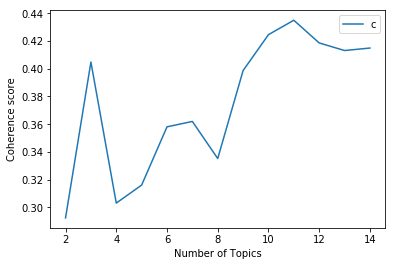

11


In [14]:

from gensim.corpora.dictionary import Dictionary

tokenizer = RegexpTokenizer(r'\w+')



corpus = d1["m"].tolist()
#print(len(corpus))
corp = []
for string in corpus:
    tokens = tokenizer.tokenize(string)
    corp.append(tokens)

common_dictionary = Dictionary(corp)
common_corpus = [common_dictionary.doc2bow(text) for text in corp]
tfidf = TfidfModel(common_corpus)
tfidf_corpus = tfidf[common_corpus]

start,stop,step=2,15,1
nTopics = plot_graph(corp,start,stop,step,tfidf_corpus,common_dictionary)

print(nTopics)


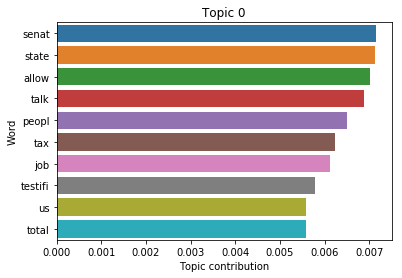

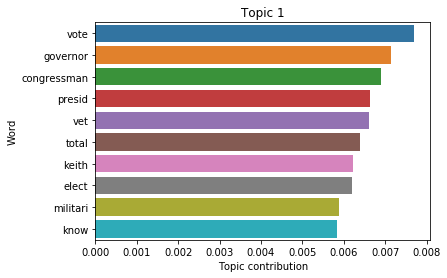

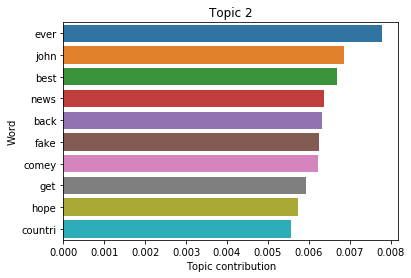

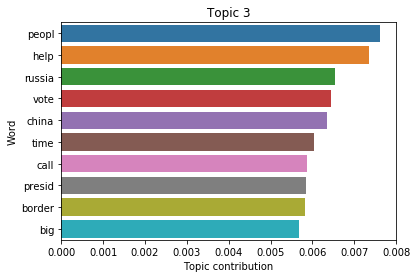

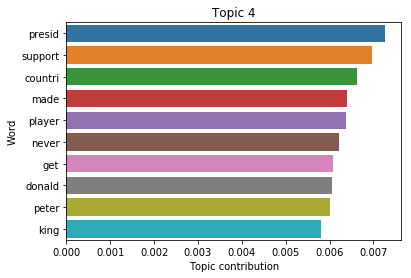

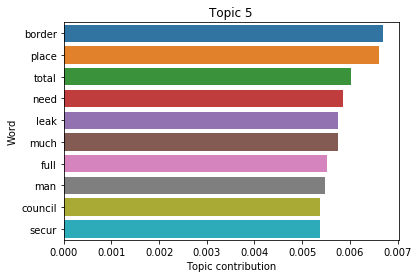

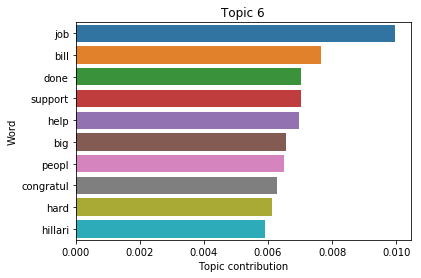

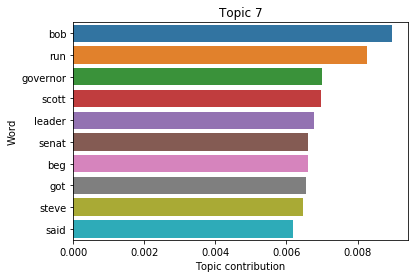

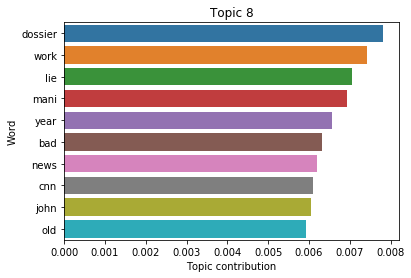

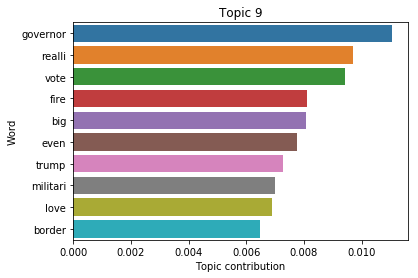

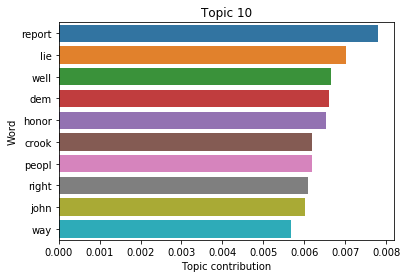

topics_count [61, 55, 53, 51, 49, 49, 45, 42, 41, 39, 29]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [16]:
lda = LdaModel(tfidf_corpus, num_topics=11, id2word=common_dictionary)

topics = lda.show_topics(num_topics=-1, num_words=10,formatted=False,log=True)
#print(g)
for topic in topics:
    words = []
    weights = []
    for word in topic[1]:
        if abs(word[1]) > 0.001:
            words.append(word[0])
            #prendi valore assoluto perchè positivo/negativo non ha senso 
            weights.append(abs(word[1]))
    labels = words
    sizes = weights
    plt.title("Topic " + str(topic[0]))
    sns.barplot(x=weights, y=words)
    plt.xlabel("Topic contribution")
    plt.ylabel("Word")
    plt.show()        
topicColumn = []
topicList = {}
for el in tfidf_corpus:
    vector = lda.get_document_topics(el)
    #get topic
    m = max(y for (x,y) in vector)
    ind = [x for x, y in enumerate(vector) if y[1] == m][0]
    #print(ind,m)
    if ind not in topicList:
        topicList[ind] = 1
    else: 
        topicList[ind] += 1
    topicColumn.append(ind)
d1["topic"] = topicColumn
#print(topicColumn)
print("topics_count",d1["topic"].value_counts().tolist())


In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Doc{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(),
                      columns=feat_names)
    return(df)
  
corpus = d1["m"].tolist()

# instantiate the vectorizer object
cvec = TfidfVectorizer()

# convert the documents into a document-term matrix
wm = cvec.fit_transform(corpus)

# retrieve the terms found in the corpora
tokens = cvec.get_feature_names()

# create a dataframe from the matrix
c = wm2df(wm, tokens)

d1.reset_index(inplace=True,drop=True)
res = pd.concat([d1,c], axis=1)
#hour peggiora di brutto e monht alza di tanto sse!!! sembra che il tempo peggiori sse e migliori silhouette
res1 = res.drop(["date_year","week_year","date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["date_year","week_year","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 
#dataWithText = res
res1.columns

Index(['vaderScore', 'topic', '2016', '2nd', 'abc', 'absolut', 'accomplish',
       'accur', 'act', 'action',
       ...
       'wow', 'written', 'wrong', 'wrote', 'xi', 'year', 'yesterday', 'yet',
       'york', 'young'],
      dtype='object', length=650)

(array([42., 61., 29., 55., 53., 39., 51., 41., 45., 98.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <a list of 10 Patch objects>)

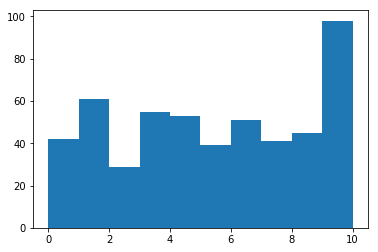

In [18]:
plt.hist(res1["topic"])

In [37]:
sil = []
for c in range(2,22):
    clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=c)
    clustering.fit(res1)
    labels = clustering.labels_
    d = silhouette_score(res1, labels,metric='cosine')
    sil.append(d)
    print(c,d)


2 0.7248319239928603
3 0.576753382105586
4 0.4994516323826884
5 0.45237056818950044
6 0.42706063767642144
7 0.4003758735657816
8 0.32581974800710395
9 0.3211945296055436
10 0.29579594455868513
11 0.3004010647479944
12 0.31168091732806213
13 0.31483951813721445
14 0.30239081861007655
15 0.2849077652153275
16 0.28936774782276553
17 0.2777484552955422
18 0.26819433993273867
19 0.27835727599236393
20 0.28213226181514806
21 0.28279480590378075


In [35]:
res1 = res.drop(["week_year","date_month","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count","m"],axis=1)
dataWithText = res.drop(["week_year","hour","noTags_punct","modded1_stemmed","labels","favorite_count","retweet_count"],axis=1) 


In [38]:
print(res1.columns)
clustering = AgglomerativeClustering(affinity='cosine', linkage='average', n_clusters=8) #50 sembra nice, 70 meh 
clustering.fit(res1)
labels = clustering.labels_
d = silhouette_score(res1, labels,metric='cosine')
print(d)

Index(['date_year', 'vaderScore', 'topic', '2016', '2nd', 'abc', 'absolut',
       'accomplish', 'accur', 'act',
       ...
       'wow', 'written', 'wrong', 'wrote', 'xi', 'year', 'yesterday', 'yet',
       'york', 'young'],
      dtype='object', length=651)
0.32581974800710395


In [39]:
res1["labels"] = labels
dataWithText["labels"] = labels


CLUSTER 4
36
2018    19
2017    10
2019     7
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


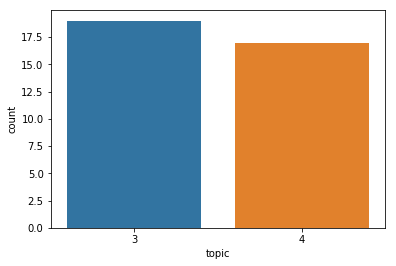

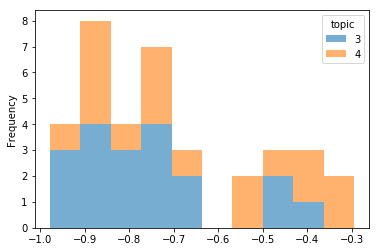

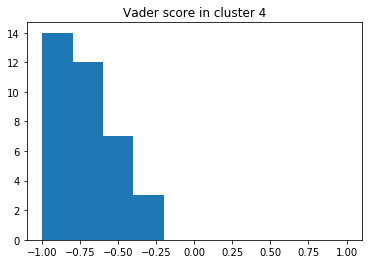

CLUSTER 3
103
2018    66
2017    23
2019    14
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


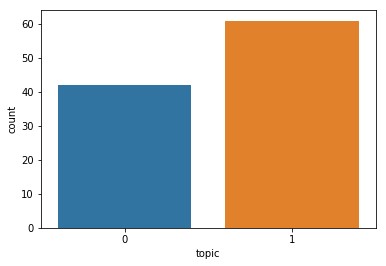

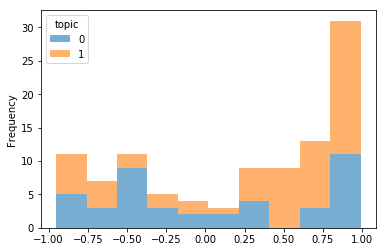

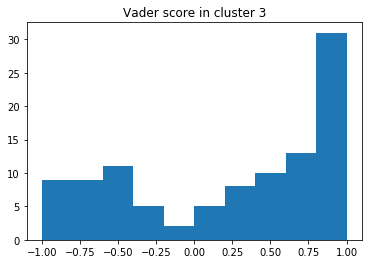

CLUSTER 2
98
2018    60
2017    25
2019    13
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


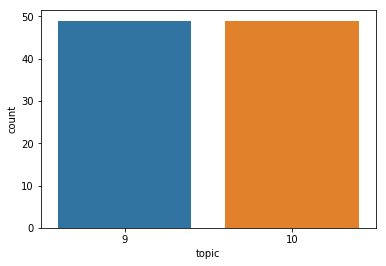

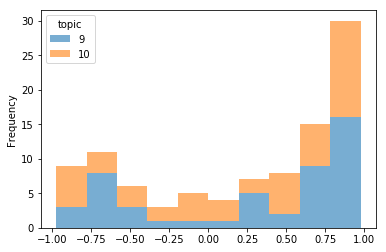

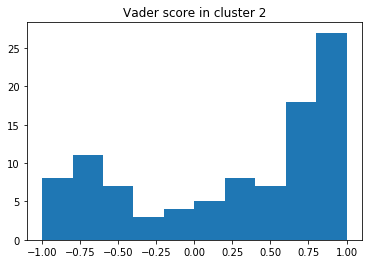

CLUSTER 0
81
2018    61
2017    13
2019     7
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


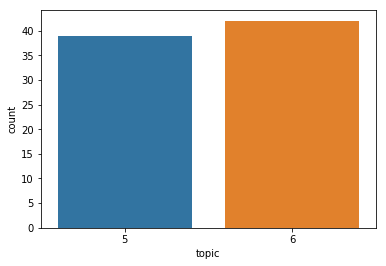

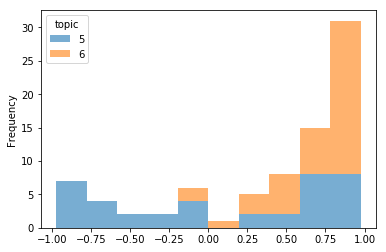

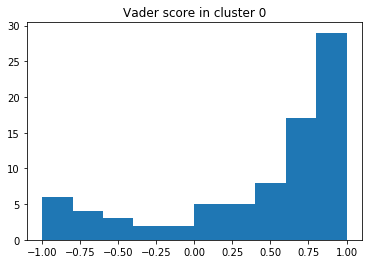

CLUSTER 5
89
2018    52
2017    31
2019     6
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


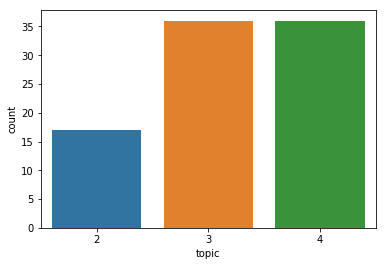

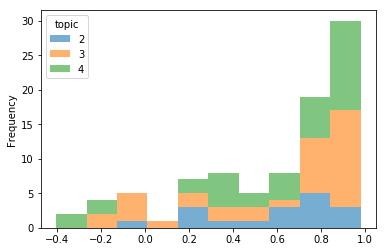

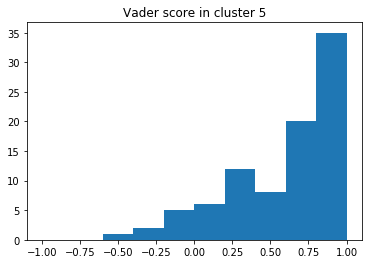

CLUSTER 6
23
2018    10
2017     7
2019     6
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


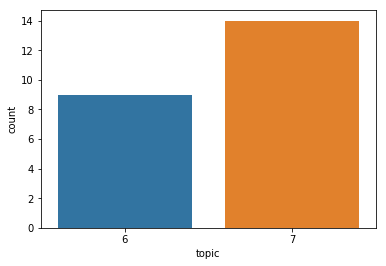

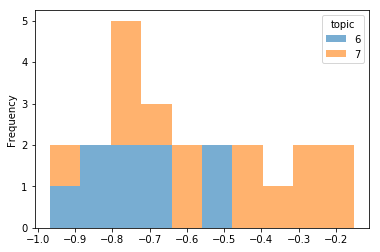

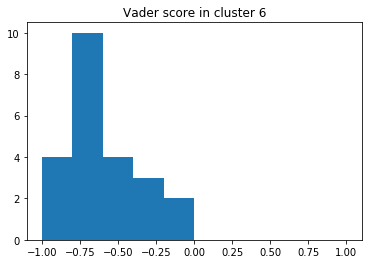

CLUSTER 1
72
2018    51
2017    18
2019     3
Name: date_year, dtype: int64
[2017, 2018, 2019]
anni nel cluster  3


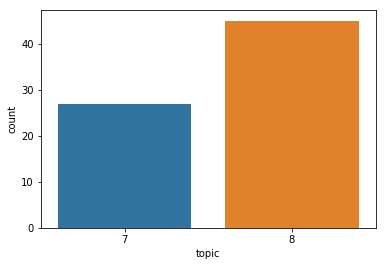

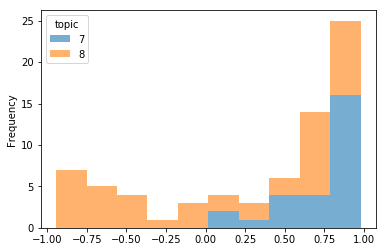

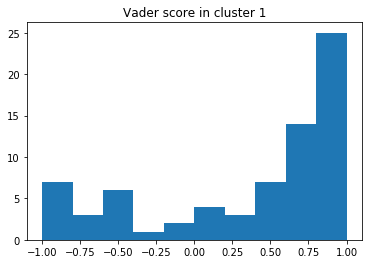

CLUSTER 7
12
2018    8
2017    4
Name: date_year, dtype: int64
[2017, 2018]
anni nel cluster  2


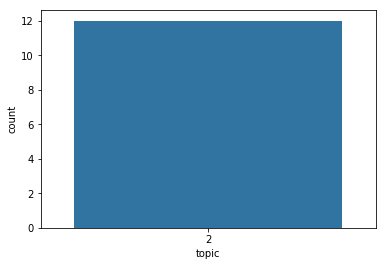

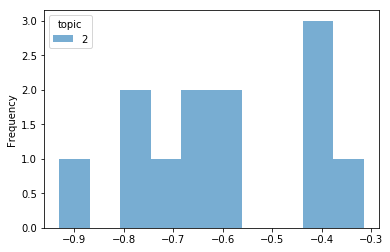

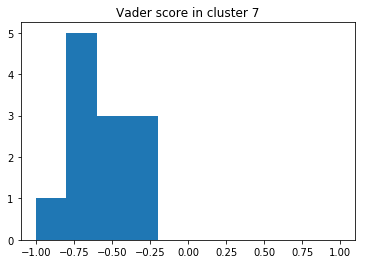

In [60]:

for cluster in res1["labels"].unique():
    g1 = res1[res1["labels"] == cluster]
   # temp = dataWithText[dataWithText["labels"] == cluster]
    

    #meanTfOrdered = sorted(meanTf, key=itemgetter(1),reverse = True)
    #print("cluster ",cluster," lunghezza ", len(g1), ":\n", str(meanTfOrdered[0:5]) + "\n")
    print("CLUSTER " + str(cluster))
    print(len(g1))
    print(g1["date_year"].value_counts())
    print(g1["date_year"].unique().tolist())
    print("anni nel cluster ", len(g1["date_year"].unique().tolist()))
    #print(temp["week_year"].unique().tolist())
   # print("numero di settimane in cluster", len(temp["week_year"].unique().tolist()))

    #plt.hist(g1["topic"],bins=[0,1,2,3,4,5,6,7,8,9,10])
    #plt.title("topicdistrib in cluster " + str(cluster))
    #plt.show()
    sns.countplot(g1["topic"])
    plt.show()

    g1.pivot(columns='topic').vaderScore.plot(kind = 'hist',alpha=0.6,stacked=True)
    plt.show()
    
    plt.hist(g1["vaderScore"],bins=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],label=g1["topic"].unique().tolist())
    plt.title("Vader score in cluster " + str(cluster) )
    plt.show()
    
    #try to make a stacked histogram to see how he differentiates the topics and what he's talking about

